In [1]:
import os
import numpy as np
import torch
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import KATNetwork

In [2]:
data = pd.read_csv('../data/BMaN_data.csv', header=None)
in_data = torch.tensor(data.iloc[:, :3].values, dtype=torch.float32)
out_data = torch.tensor(data.iloc[:, 3:].values, dtype=torch.float32)

in_data_min = in_data.min(dim=0).values
in_data_max = in_data.max(dim=0).values
in_data = (in_data - in_data_min) / (in_data_max - in_data_min)

out_data_min = out_data.min(dim=0).values
out_data_max = out_data.max(dim=0).values
out_data = (out_data - out_data_min) / (out_data_max - out_data_min)

print("in_data min:", in_data_min)
print("in_data max:", in_data_max)
print("out_data min:", out_data_min)
print("out_data max:", out_data_max)

print("in_data shape:", in_data.shape)
print("out_data shape:", out_data.shape)


in_data min: tensor([-251.9720,  -77.6700, -287.4100])
in_data max: tensor([241.0120,  94.3300, 564.2900])
out_data min: tensor([ -5.4150, -13.1449,  -5.4964])
out_data max: tensor([5.1087, 3.1548, 5.4806])
in_data shape: torch.Size([6111402, 3])
out_data shape: torch.Size([6111402, 3])


In [3]:
train_dataset = TensorDataset(in_data, out_data)
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device, "device")

Using cuda device


In [5]:
def compute_divergence(y, x):
    assert y.shape == x.shape, "Output and input must have the same shape"
    divergence = torch.zeros(x.shape[0], device=x.device)
    
    for i in range(y.shape[1]):
        grad = torch.autograd.grad(
            outputs=y[:, i],
            inputs=x,
            grad_outputs=torch.ones_like(y[:, i]),
            create_graph=True,
            retain_graph=True,
            allow_unused=False
        )[0]
        divergence += grad[:, i]
    
    return divergence

In [5]:
def rms_loss(pred, target):
    loss = (pred - target) ** 2
    return torch.sqrt(loss.mean())

def loss_fn(input, pred, target, weights, sigmas, gamma=0.0001, beta=0.0001):
    rms_loss = torch.sqrt(torch.mean((pred - target) ** 2))
    #divergence_loss = torch.sqrt(torch.mean(compute_divergence(pred, input)**2))

    reg = []
    for i in range(len(weights)):
        r = torch.abs(weights[i])
        reg.append(r.sum())
    
    return rms_loss + gamma * torch.stack(reg).sum() #+ beta * divergence_loss

In [ ]:
model = KATNetwork.KATMLP(3, [21], 3, [(0, 1), (-1, 1)], 20).to(device) 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.95)
""" optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,              
    max_iter=50,
    max_eval=50,       
    history_size=200,
    line_search_fn='strong_wolfe'
) """

In [ ]:
criterion = loss_fn
num_epochs = 30

train_loss_list = []

for epoch in range(num_epochs):
        model.train()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            #inputs.requires_grad_(True)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(inputs, outputs, targets, 
                            [model.model[i].w for i in range(len(model.model))], 
                            [model.model[i].sigma for i in range(len(model.model))])

            loss.backward()

            optimizer.step()

            """ def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(inputs, outputs, targets, 
                                [model.model[i].w for i in range(len(model.model))], 
                                [model.model[i].sigma for i in range(len(model.model))])

                loss.backward()

                return loss

            optimizer.step(closure) """
        
        model.eval()
        train_loss = 0.0

        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                loss = rms_loss(outputs, targets)

                train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        train_loss_list.append(train_loss)

        scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5e}")

In [10]:
output_dir = '../bman_model/'

model_save_path = os.path.join(output_dir, 'adamw_model_checkpoint.pth')

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

if os.path.exists(model_save_path):
    os.remove(model_save_path)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, model_save_path)
print('Model saved')

Model saved


In [11]:
model_save_path = '../bman_model/model_checkpoint.pth'

if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, weights_only=True, map_location=device)
    if 'model_state_dict' in checkpoint and 'optimizer_state_dict' in checkpoint and 'epoch' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f'Loaded checkpoint from epoch {checkpoint['epoch'] + 1}')
    else:
        print('Checkpoint file is missing some keys, starting from scratch.')

Loaded checkpoint from epoch 10


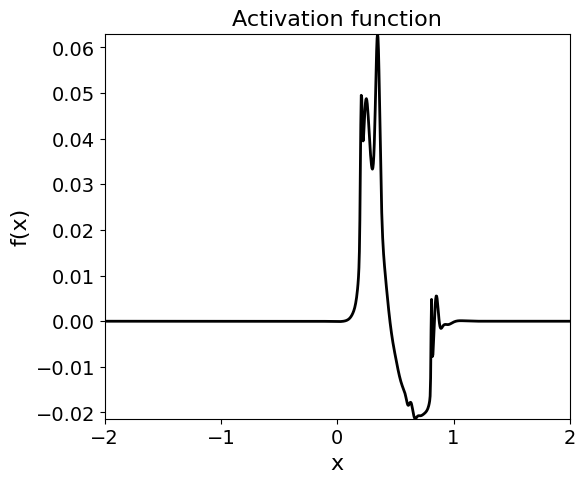

In [11]:
xlist = np.linspace(-2, 2, 1000).tolist()
ylist = [model.model[0].eval_func(x, 0, 0) for x in xlist]

plt.figure(figsize=(6, 5))
plt.plot(xlist, ylist, color='black', linestyle='-', linewidth=2)
plt.xlabel("x", fontsize=16)
plt.ylabel("f(x)", fontsize=16)
plt.title("Activation function", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-2, 2)
plt.ylim(min(ylist), max(ylist))
plt.show()

In [14]:
ntest = 201
xrange = (0, 1)
yrange = (0, 1)
zrange = (0, 1)

Xtest, Ytest, Ztest = np.meshgrid(np.linspace(*xrange, ntest), np.linspace(*yrange, ntest), np.linspace(*zrange, ntest))
in_test_data = torch.tensor(np.array([Xtest.ravel(), Ytest.ravel(), Ztest.ravel()]).T, dtype=torch.float32)

In [15]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

test_dataset = TestDataset(in_test_data)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [16]:
model.eval()

pred_values = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        pred_values.append(outputs.cpu())

pred_values = torch.cat(pred_values, dim=0)

with open('../results/fit_results.txt', mode='w') as file:
    for i in range(in_test_data.size(0)):
        file.write(f'{in_test_data[i, 0].item():.5f}\t{in_test_data[i, 1].item():.5f}\t{in_test_data[i, 2].item():.5f}\t{pred_values[i, 0].item():.5f}\t{pred_values[i, 1].item():.5f}\t{pred_values[i, 2].item():.5f}\n')

print("Results are saved in 'results.txt'.")

Results are saved in 'results.txt'.


In [ ]:
print(train_loss_list)

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, len(train_loss_list)+1)], train_loss_list, color='black', linestyle='-', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("RMS")
plt.title("True vs Predicted")
plt.xlim(0.95, 1.05 * len(train_loss_list))
plt.ylim(1e-3, 2e-2)
plt.xscale('log')
plt.yscale('log')
plt.show()